In [1]:
%autosave 15
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.optimize as sopt
import pandas as pd
import math
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Autosaving every 15 seconds


In [2]:
def printAllPoints(data, classes):
    green = [[], []]
    blue = [[], []]
    for (x, y) in data:
        if (classes[(x, y)] == 0):
            green[0].append(x)
            green[1].append(y)
        else:
            blue[0].append(x)
            blue[1].append(y)
    plt.plot(green[0], green[1], 'g.', blue[0], blue[1], 'b.')

In [3]:
def get_data(transform, name):
    fin = open('chips.txt', 'r')
    lines = fin.readlines()
    fin.close()
    
    classes = dict()
    data = list()
    
    for x, y, z in [map(float, x.split(',')) for x in lines]:
        a, b = transform(x, y)
        data.append((a, b))
        classes[(a, b)] = z
    
    return (data, classes, name, transform)

In [4]:
def toPolar(x, y, x0, y0):
    x, y = x - x0, y - y0
    r = (x ** 2 + y ** 2) ** (1 / 2)
    a = math.atan2(x, y)
    return (r, a)

def getCenter():
    fin = open('chips.txt', 'r')
    lines = fin.readlines()
    fin.close()

    x0, y0 = 0, 0
    for x, y, z in [map(float, x.split(',')) for x in lines]:
        x0 += x
        y0 += y
    x0 = x0 / len(lines)
    y0 = y0 / len(lines)
    
    return (x0, y0)

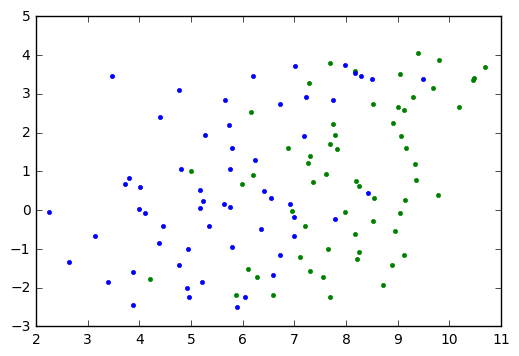

In [5]:
simpleData = get_data(lambda x, y:(x, y), '-')
sumData = get_data(lambda x, y:(x, x + y), 'x, y -> x, x + y')
polarData = get_data(lambda x, y: toPolar(x, y, 0, 0), 'polar(0, 0)')

center = getCenter()
polarData2 = get_data(lambda x, y: toPolar(x, y, center[0], center[1]), 'polar(center_x, center_y)')



wideData = get_data(lambda x, y: (toPolar(x, y, center[0], center[1])[0] * 10, 
                           toPolar(x, y, center[0], center[1])[0] + toPolar(x, y, center[0], center[1])[1]
                          ), 
             'wide')
printAllPoints(wideData[0], wideData[1])


data = [simpleData, sumData, polarData, polarData2, wideData]

In [ ]:
printAllPoints(wideData[0], wideData[1])

In [ ]:
printAllPoints(simpleData[0], simpleData[1])

In [ ]:
printAllPoints(sumData[0], sumData[1])

In [ ]:
printAllPoints(polarData[0], polarData[1])

In [ ]:
printAllPoints(polarData2[0], polarData2[1])

In [6]:
def minkowskiDistance(x, y, p):
    res = 0
    for i in range(len(x)):
        res += abs(x[i] - y[i]) ** p
    return res ** (1 / p)

# https://en.wikipedia.org/wiki/Cosine_similarity
def cosineSimilarity(x, y):
    res, a, b = 0, 0, 0
    for i in range(len(x)):
        res += x[i] * y[i]
        a += x[i] ** 2
        b += y[i] ** 2
    a = a ** (1 / 2)
    b = b ** (1 / 2)
    return res / a / b
    

metrics = [lambda x, y: minkowskiDistance(x, y, 1), 
           lambda x, y: minkowskiDistance(x, y, 2)
          ]
#lambda x, y: cosineSimilarity(x, y)]    

metric_names = dict()
metric_names[metrics[0]] = 'minkowski with p = 1'
metric_names[metrics[1]] = 'minkowski with p = 2'
#metric_names[metrics[2]] = 'cosine'

#for metric in metrics:
#    print(metric((1, 1), (2, 2)))

In [7]:
def k_fold_cv(k, length):
    one_fold_length = length // k
    others = length % k
    indexies = [i for i in range(length)]
    result = list()
    for i in range(k):
        test_suit = list()
        train_suit = list()

        for j in range(one_fold_length):
            index = indexies[int(np.random.uniform(0, len(indexies))) % len(indexies)]
            test_suit.append(index)
            indexies.remove(index)
        if others > 0:
            others -= 1
            index = indexies[int(np.random.uniform(0, len(indexies))) % len(indexies)]
            test_suit.append(index)
            indexies.remove(index)
        
        for j in range(length):
            if j not in test_suit:
                train_suit.append(j)
        
        result.append((train_suit, test_suit))
    return result

In [8]:
def predict_class(k, metric, learn_suit, classes, point, kernel):
    distances = [(metric(l_point, point), l_point) for l_point in learn_suit]
    distances.sort()
    
    d = distances[k][0]
    if (d == 0):
        d = 1
    
    s = [0, 0]
    for j in range(k):
        dist, p = distances[j]
        s[int(classes[p])] += kernel(dist / d)
        
    if (s[0] > s[1]):
        return 0
    else:
        return 1

In [9]:
def kNN(metric, data, classes, kernel, cv_params = (1, 10)):
    
    def compute_score(k, train_suit, test_suit):
        true_positive = [0, 0]
        false_positive = [0, 0]
        all_points = [0, 0]

        for point in test_suit:
            predicted = predict_class(k, metric, train_suit, classes, point, kernel)
            real_class = int(classes[point])
            
            if predicted == real_class:
                true_positive[predicted] += 1
            else:
                false_positive[predicted] += 1
            all_points[real_class] += 1
                
        if true_positive[1] > 0:
            recall = true_positive[1] / all_points[1]
            precision = true_positive[1] / (true_positive[1] + false_positive[1])
            # F1 measure
            return 2 * (precision * recall) / (precision + recall)
        return 0


    tfold, kfold = cv_params
    max_neighbors = 0
    max_score = 0
    for neighbors in range(2, int(np.sqrt(len(data)))):
        average_score = 0
        for i in range(tfold):
            kfold_index = k_fold_cv(kfold, len(data))
            score = 0
            for train_suit, test_suit in kfold_index:
                training_suit = [data[i] for i in train_suit]
                testing_suit = [data[i] for i in test_suit]
                score += compute_score(neighbors, training_suit, testing_suit)
            average_score += score
        
        average_score /= (tfold * kfold)
        
        if average_score > max_score:
            max_neighbors = neighbors
            max_score = average_score
    
    return (max_neighbors, max_score)

In [10]:
kernels = [
    (lambda x: 1 / 2, 'uniform'),
    (lambda x: 1 - abs(x), 'triangular'),
    (lambda x: 3 / 4 * (1 - x * x), 'parabolic'),
    (lambda x: (1 - x ** 2) ** 2 * 15 / 16, 'quartic')
]

In [11]:
results = pd.DataFrame(columns=['k', 'metric', 'accuracy'])


best_accuracy = 0
best_kernel   = None
best_metric   = None
best_data     = None
best_neighbor = None
best_kfold = None

pd.set_option('display.height', 250)
pd.set_option('display.max_rows', 250)

for kfold in range(5, 11):
    for kernel in kernels:
        for metric in metrics:
            for input_data, classes, transform_name, transform in data:
                k, accuracy = (kNN(metric, input_data, classes, kernel[0], (1, kfold)))
                raw = pd.DataFrame([[kfold, k, metric_names[metric], transform_name, accuracy, kernel[1]]], columns=['folds', 'k', 'metric', 'transformation name', 'accuracy', 'kernel'])
                results = results.append(raw, ignore_index=True)
            
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_kernel = kernel[0]
                    best_metric = metric
                    best_data = (input_data, classes, transform)
                    best_neighbor = k
                    best_kfold = kfold
                
                    best_string = str(accuracy) + ', ' + str(k) + ', ' + kernel[1] + ', ' + metric_names[metric] + ", " + transform_name + " folds: " + str(best_kfold)

display(results)

height has been deprecated.



KeyboardInterrupt: 

In [ ]:
green = [[], []]
blue = [[], []]

for x in np.arange(-1, 1.5, 0.01):
    for y in np.arange(-1, 1.5, 0.01):
        predicted = predict_class(best_neighbor, best_metric, best_data[0], best_data[1], best_data[2](x, y), best_kernel)

        if (predicted == 0):
            green[0].append(x)
            green[1].append(y)
        else:
            blue[0].append(x)
            blue[1].append(y)

plt.title(best_string)
plt.plot(green[0], green[1], 'g.', blue[0], blue[1], 'b.')

In [ ]:
printAllPoints(simpleData[0], simpleData[1])

In [15]:
def get_class(x, classes):
    temp = classes[x]
    if temp == 0:
        return -1
    else:
        return 1

def lagrange(lambdas, train_suit, classes, kernel):
    result = -sum(lambdas)
    
    for i in range(len(train_suit)):
        for j in range(len(train_suit)):
            x_i = train_suit[i]
            x_j = train_suit[j]
            result += lambdas[i] * lambdas[j] * get_class(x_i, classes) * get_class(x_j, classes) * kernel(x_i, x_j)
    return result

def get_constraint(train_suit, classes):
    def constraint(x):
        result = 0
        for i in range(len(x)):
            result += get_class(train_suit[i], classes) * x[i]
        return result
    return constraint
    
def predict_svm(point, kernel, w, w0):
    result = kernel(point, w) - w0
    if result < 0:
        return 0
    return 1

# training_suit = []
# classes = {}

def SVM(data, classes, kernel, C, cv_params = (1, 10)):

    tfold, kfold = cv_params
    kfold_index = k_fold_cv(kfold, len(data))
    max_score = 0
    TP  = [0, 0]
    FP  = [0, 0]
    ALL = [0 , 0]
    for train_suit, test_suit in kfold_index:
        training_suit = [data[i] for i in train_suit]
        testing_suit = [data[i] for i in test_suit]
        def lagrange_gradient(x, *args):
            def dv_dxi(i):
                result = -1
                for j in range(len(x)):
                    x_i = training_suit[i]
                    x_j = training_suit[j]

                    result += x[j] * get_class(x_i, classes) * get_class(x_j, classes) * kernel(x_i, x_j)
                return result
            return [dv_dxi(i) for i in range(len(x))]


        lambdas = sopt.minimize(lagrange, 
                                np.array([0 for i in range(len(training_suit))]), 
                                (training_suit, classes, kernel), 
                                jac=lagrange_gradient, 
                                bounds=[(0,C) for i in range(len(training_suit))],
                                constraints={'type':'eq', 'fun':get_constraint(training_suit, classes)})

        w = np.array([0 for i in range(len(training_suit[0]))], dtype='float64')
        for i in range(len(training_suit)):
            lambda_i = lambdas.x[i]
            y_i = get_class(training_suit[i], classes)
            x_i = training_suit[i]
            w += np.array([lambda_i * y_i * x_i[j] for j in range(len(x_i))], dtype='float64')
            
        w0 = 0
        count = 0
        for i in range(len(lambdas.x)):
            lambda_i = lambdas.x[i]
            if lambda_i > 0:
                w0 += kernel(w, training_suit[i]) - get_class(training_suit[i], classes)
                count += 1
        if count != 0:
            w0 /= count
        
        for point in testing_suit:
            predicted = int(predict_svm(point, kernel, w, w0))
            real_class = int(classes[point])
            if predicted == real_class:
                TP[predicted] += 1
            else:
                FP[predicted] += 1
            ALL[real_class] += 1
        
    if TP[1] > 0:
        recall = TP[1] / ALL[1]
        precision = TP[1] / (TP[1] + FP[1])
        # F1 measure
        return 2 * (precision * recall) / (precision + recall), (kernel, w, w0)
    return 0, (kernel, w, w0)

In [13]:
def simple_kernel(x, y):
    return sum(np.array(x) * np.array(y))

def square_kernel(x, y):
    return simple_kernel(x, y) ** 2

def paraboloid_kernel(x, y):
    return simple_kernel([x[0], x[1], x[0]**2 + x[1]**2], [y[0], y[1], y[0]**2 + y[1]**2])

def parab(data):
    w = np.array([0, 0], dtype='float64')
    input_data, classes, transform_name, transform = data
    for point in input_data:
        w += np.array(point, dtype='float64')
    w /= len(data)
    def kernel(x, y):
        return simple_kernel([x[0], x[1], (x[0] - w[0])**2 + (x[1] - w[1])**2], [y[0], y[1], (y[0] - w[0])**2 + (y[1] - w[1])**2])
    return kernel


def paraboloid_kernel2(x, y):
    return square_kernel([x[0], x[1], x[0]**2 + x[1]**2], [y[0], y[1], y[0]**2 + y[1]**2])

def gaussianKernel(sigma=1):
    FG = lambda x : np.array([(x[0]**2 + x[1]**2) , x[0], x[1]])
    return lambda x, y: np.exp(-np.dot(FG(np.array(x) - np.array(y)),  FG(np.array(x) - np.array(y))) / (2 * (sigma ** 2)))

bikernels = [(parab(simpleData), 'square paraboloid'),
             (gaussianKernel(1), 'gaussian'),
             (simple_kernel, '<x,y>'),
             (square_kernel, '<x,y>^2'),
             (paraboloid_kernel, 'simple paraboloid'),
             ]

svm_data = [data[0], data[-2], data[-1]]

In [16]:
current = 0
bext = None
for kfold in [5]:
    for kernel in bikernels:
        for input_data, classes, transform_name, transform in svm_data:
            for C in [0.114]:
                score, tmp = SVM(input_data, classes, kernel[0], C, cv_params=(1,kfold))
                if current < score:
                    current = score
                    bext = tmp
                print(kernel[1], transform_name, score)

square paraboloid - 0.49572649572649574
square paraboloid polar(center_x, center_y) 0.5565217391304348
square paraboloid wide 0.2434782608695652
gaussian - 0.5901639344262296
gaussian polar(center_x, center_y) 0.3584905660377358
gaussian wide 0.380952380952381
<x,y> - 0.3157894736842105
<x,y> polar(center_x, center_y) 0.735042735042735
<x,y> wide 0.7818181818181817
<x,y>^2 - 0.22222222222222224
<x,y>^2 polar(center_x, center_y) 0.3619047619047619
<x,y>^2 wide 0.16091954022988508
simple paraboloid - 0.4285714285714286
simple paraboloid polar(center_x, center_y) 0.43636363636363634
simple paraboloid wide 0.22608695652173913


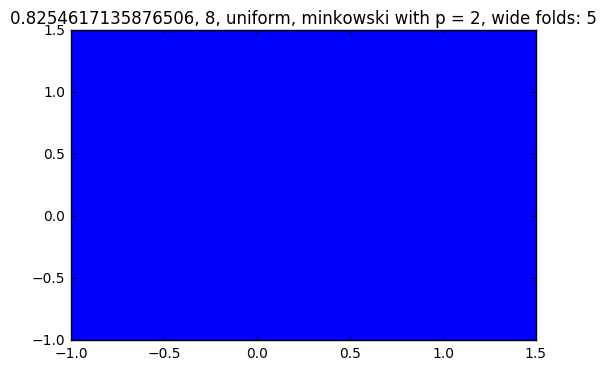

In [17]:
green = [[], []]
blue = [[], []]
krnl, w, w0 = bext
for x in np.arange(-1, 1.5, 0.01):
    for y in np.arange(-1, 1.5, 0.01):
        predicted = predict_svm((x,y), krnl, w, w0)

        if (predicted == 0):
            green[0].append(x)
            green[1].append(y)
        else:
            blue[0].append(x)
            blue[1].append(y)

plt.title(best_string)
plt.plot(green[0], green[1], 'g.', blue[0], blue[1], 'b.')